# PeerDAS + BPO bandwidth estimations

This notebook estimates bandwidth requirements for various blob limits and network conditions, using EIP-7870 bandwidth limits as reference, in order to inform optimal BPO parameter setting in the context of EIP-7892 (Blob Parameter Only forks).

## Current status

This version is just a first LLM-generated flush. It doesn't do a good job at modelling what we want yet. **Only use it as a skeleton.**

## TODO

**Model parameters:**

- Parameterize blob limits starting from Pectra (6/9), all the way up to 64/72 (Fusaka target post BPO), and stretch to 96/128.
- EIP-7870 node profiles and up/down bandwidth caps.
- Total beacon node count: today (~13k) and 2x today.
- Custody / supernode distribution (reference was posted in Scale the Blobs channel, extrapolated from vals.sigp.io).
- Time allocated for distribution (1s to 3.5s).
- Competing traffic during distribution, in a simple way: reserve bandwidth for the blobpool (see below), block propagation, mempool, etc.
- Private/public blob ratio. Start at 20% (today's measurement) and go all the way up to 60% private.
- Blobpool: model full replication (today) and sparse blobpool (6.67x reduction over full replication). Compute required bandwidth based on blob limits and assume a steady flux.
- Gossipsub partial messages support (effectiveness depends on private/public blob ratio).
- Gossipsub duplicate / non-delivery overhead, simplified: can assume 1.5x?
- Network inefficiency factor: just a simple multiplier to account for packet loss, latency, etc.
- Compute inefficiency factor: add some time to account for compute overhead, processing delays, etc.

**Model outputs:**

Some core plots include:
- Bandwidth requirement per limit, per node type, plotted against their respective caps.
- CDF of column propagation per limit, over node types.
- Peak load / average load.
- ...

We'll need these plotted for various scenarios (determined by parameters).

In [1]:
!uv add requests pandas pyarrow plotly kaleido nbformat numpy
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Set the default theme to a modern dark theme
pio.templates.default = "plotly_dark"

Resolved 120 packages in 0.87ms
Audited 114 packages in 0.84ms


## EIP-7870 and EIP-7892 Constants

In [2]:
# Current Pectra Constants
CURRENT_TARGET_BLOBS_PER_BLOCK = 6
CURRENT_MAX_BLOBS_PER_BLOCK = 9
BYTES_PER_BLOB = 131072  # 128 KiB
BYTES_PER_EXTENDED_BLOB = 262144 # 256 KiB
SECONDS_PER_SLOT = 12
INTERVALS_PER_SLOT = 3  # Each slot has 3 intervals
SECONDS_PER_INTERVAL = SECONDS_PER_SLOT // INTERVALS_PER_SLOT  # 4 seconds

# Network propagation constants
NETWORK_HOPS = 3  # Typical number of hops for message propagation
SECONDS_PER_HOP = SECONDS_PER_INTERVAL / NETWORK_HOPS  # 1.33 seconds per hop

# PeerDAS Constants (EIP-7594)
NUMBER_OF_COLUMNS = 128  # Total number of columns in the DAS matrix
DATA_COLUMN_SIDECAR_SUBNET_COUNT = 128  # Number of data column subnets
SAMPLES_PER_SLOT = 16  # Number of columns to sample per slot
CUSTODY_REQUIREMENT = 4  # Minimum custody requirement for nodes (out of 128 columns)

# PeerDAS Custody Scenarios
CUSTODY_SCENARIOS = [
    {"name": "Minimum", "custody_count": 4, "percentage": 4/128},  # 3.125%
    {"name": "Light", "custody_count": 8, "percentage": 8/128},  # 6.25%
    {"name": "Standard", "custody_count": 16, "percentage": 16/128},  # 12.5%
    {"name": "Heavy", "custody_count": 32, "percentage": 32/128},  # 25%
    {"name": "Super", "custody_count": 64, "percentage": 64/128},  # 50%
    {"name": "Full", "custody_count": 128, "percentage": 128/128},  # 100% (current non-DAS behavior)
]

# EIP-7870 Bandwidth Limits (official specification)
# Source: https://eips.ethereum.org/EIPS/eip-7870
EIP_7870_BANDWIDTH_LIMITS = {
    "eip7870_full_node": {"down": 50 * 1024 * 1024 / 8, "up": 15 * 1024 * 1024 / 8},  # 50/15 Mbps in bytes/second
    "eip7870_attester": {"down": 50 * 1024 * 1024 / 8, "up": 25 * 1024 * 1024 / 8},  # 50/25 Mbps in bytes/second
    "eip7870_local_block_builder": {"down": 100 * 1024 * 1024 / 8, "up": 50 * 1024 * 1024 / 8},  # 100/50 Mbps in bytes/second
}

# Additional common connection types for reference
ADDITIONAL_CONNECTION_TYPES = {
    "home_cable": {"down": 200 * 1024 * 1024 / 8, "up": 20 * 1024 * 1024 / 8},  # 200/20 Mbps cable (typical asymmetric)
    "home_fiber": {"down": 300 * 1024 * 1024 / 8, "up": 100 * 1024 * 1024 / 8},  # 300/100 Mbps fiber
    "institutional": {"down": 1000 * 1024 * 1024 / 8, "up": 1000 * 1024 * 1024 / 8},  # 1 Gbps symmetric
}

# Combine for analysis
ALL_CONNECTION_TYPES = {**EIP_7870_BANDWIDTH_LIMITS, **ADDITIONAL_CONNECTION_TYPES}

# EIP-7892 Proposed Blob Limits (various scenarios)
BLOB_LIMIT_SCENARIOS = [
    {"name": "Pre-Pectra (EIP-4844)", "target": 3, "max": 6},
    {"name": "Current (Pectra)", "target": 6, "max": 9},
    {"name": "Conservative +", "target": 8, "max": 12},
    {"name": "Moderate", "target": 10, "max": 15},
    {"name": "Moderate+", "target": 12, "max": 18},
    {"name": "Progressive", "target": 16, "max": 24},
    {"name": "Aggressive", "target": 20, "max": 30},
    {"name": "Aggressive+", "target": 24, "max": 36},
    {"name": "High Scale", "target": 30, "max": 45},
    {"name": "High Scale+", "target": 36, "max": 54},
    {"name": "Ultra Scale", "target": 40, "max": 60},
    {"name": "Ultra Scale+", "target": 48, "max": 72},
    {"name": "Maximum", "target": 60, "max": 90},
]

# Network overhead factors
GOSSIP_OVERHEAD = 1.5  # Assume 50% overhead for gossip propagation
PEAK_FACTOR = 2.0  # Peak usage can be 2x average
BANDWIDTH_AVAILABLE_FACTOR = 0.8  # 80% of bandwidth available for blob propagation (remainder reserved for other network operations)

# Node bandwidth factors (independent scaling for upload/download)
# These factors multiply the base bandwidth requirement
NODE_BANDWIDTH_FACTORS = {
    "validator": {"down_factor": 1.0, "up_factor": 1.2},  # Validators upload slightly more due to block proposals
    "non_validator": {"down_factor": 1.0, "up_factor": 1.0},  # Standard gossip behavior
    "balanced": {"down_factor": 1.0, "up_factor": 1.0},  # Balanced/average case
}

## Bandwidth Calculation Functions

In [3]:
def calculate_bandwidth_requirements(target_blobs, max_blobs, node_role="balanced", custody_count=None, use_peerdas=False):
    """Calculate upload and download bandwidth requirements for given blob parameters.
    
    Args:
        target_blobs: Target number of blobs per block
        max_blobs: Maximum number of blobs per block
        node_role: Node role ("validator", "non_validator", "balanced")
        custody_count: Number of columns to custody in PeerDAS (if None, uses full blob propagation)
        use_peerdas: Whether to use PeerDAS column propagation or full blob propagation
    """
    
    # Base calculations
    avg_data_per_slot = target_blobs * BYTES_PER_BLOB
    max_data_per_slot = max_blobs * BYTES_PER_BLOB
    
    # Apply PeerDAS reduction if enabled
    if use_peerdas and custody_count is not None:
        # In PeerDAS, each blob is extended
        avg_data_per_slot = target_blobs * BYTES_PER_EXTENDED_BLOB
        max_data_per_slot = max_blobs * BYTES_PER_EXTENDED_BLOB
        # In PeerDAS, nodes only propagate columns they custody
        das_reduction_factor = custody_count / NUMBER_OF_COLUMNS
        avg_data_per_slot *= das_reduction_factor
        max_data_per_slot *= das_reduction_factor
    
    # Base bandwidth in bytes per second - using per-hop timing (1 second per hop)
    avg_bandwidth_base = avg_data_per_slot / SECONDS_PER_HOP
    max_bandwidth_base = max_data_per_slot / SECONDS_PER_HOP
    
    # With gossip overhead
    avg_bandwidth_gossip = avg_bandwidth_base * GOSSIP_OVERHEAD
    max_bandwidth_gossip = max_bandwidth_base * GOSSIP_OVERHEAD
    
    # Apply node-specific bandwidth factors
    factors = NODE_BANDWIDTH_FACTORS[node_role]
    
    # Calculate download and upload bandwidth using factors
    avg_download = avg_bandwidth_gossip * factors["down_factor"]
    avg_upload = avg_bandwidth_gossip * factors["up_factor"]
    
    max_download = max_bandwidth_gossip * factors["down_factor"]
    max_upload = max_bandwidth_gossip * factors["up_factor"]
    
    # Peak scenarios
    peak_download = avg_download * PEAK_FACTOR
    peak_upload = avg_upload * PEAK_FACTOR
    peak_max_download = max_download * PEAK_FACTOR
    peak_max_upload = max_upload * PEAK_FACTOR
    
    # Total bandwidth is the sum of upload and download
    avg_bandwidth_total = avg_download + avg_upload
    max_bandwidth_total = max_download + max_upload
    
    return {
        "avg_bandwidth_total": avg_bandwidth_total,
        "max_bandwidth_total": max_bandwidth_total,
        "avg_download": avg_download,
        "avg_upload": avg_upload,
        "max_download": max_download,
        "max_upload": max_upload,
        "peak_download": peak_download,
        "peak_upload": peak_upload,
        "peak_max_download": peak_max_download,
        "peak_max_upload": peak_max_upload,
        # Convert to Mbps for display
        "avg_download_mbps": avg_download * 8 / (1024 * 1024),
        "avg_upload_mbps": avg_upload * 8 / (1024 * 1024),
        "max_download_mbps": max_download * 8 / (1024 * 1024),
        "max_upload_mbps": max_upload * 8 / (1024 * 1024),
        "peak_download_mbps": peak_download * 8 / (1024 * 1024),
        "peak_upload_mbps": peak_upload * 8 / (1024 * 1024),
        "avg_bandwidth_total_mbps": avg_bandwidth_total * 8 / (1024 * 1024),
        "max_bandwidth_total_mbps": max_bandwidth_total * 8 / (1024 * 1024),
        # Additional metadata
        "custody_count": custody_count if use_peerdas else None,
        "das_reduction": (custody_count / NUMBER_OF_COLUMNS) if use_peerdas and custody_count else 1.0,
        "use_peerdas": use_peerdas,
    }

def check_node_compatibility(download_req, upload_req, node_type_bandwidth):
    """Check if a node type can handle the bandwidth requirements."""
    # Use the available bandwidth factor for blob propagation
    available_down = node_type_bandwidth["down"] * BANDWIDTH_AVAILABLE_FACTOR
    available_up = node_type_bandwidth["up"] * BANDWIDTH_AVAILABLE_FACTOR
    return download_req <= available_down and upload_req <= available_up

# Calculate requirements for all scenarios WITHOUT PeerDAS (current behavior)
print("=" * 80)
print("BANDWIDTH REQUIREMENTS - FULL BLOB PROPAGATION (Current)")
print(f"Using {NETWORK_HOPS} network hops, {SECONDS_PER_HOP} second per hop")
print("=" * 80)

results_full = []
for scenario in BLOB_LIMIT_SCENARIOS:
    reqs = calculate_bandwidth_requirements(scenario["target"], scenario["max"], "balanced", use_peerdas=False)
    
    # Check compatibility with different node types
    compatibility = {}
    for node_type, bandwidth in ALL_CONNECTION_TYPES.items():
        compatibility[f"{node_type}_avg"] = check_node_compatibility(
            reqs["avg_download"], reqs["avg_upload"], bandwidth
        )
        compatibility[f"{node_type}_max"] = check_node_compatibility(
            reqs["max_download"], reqs["max_upload"], bandwidth
        )
        compatibility[f"{node_type}_peak"] = check_node_compatibility(
            reqs["peak_download"], reqs["peak_upload"], bandwidth
        )
    
    results_full.append({
        "scenario": scenario["name"],
        "target_blobs": scenario["target"],
        "max_blobs": scenario["max"],
        "method": "Full Blob",
        **reqs,
        **compatibility
    })

df_results_full = pd.DataFrame(results_full)

# Calculate requirements WITH PeerDAS for different custody counts
print("=" * 80)
print("BANDWIDTH REQUIREMENTS - PEERDAS COLUMN PROPAGATION")
print("=" * 80)

results_peerdas = []
for scenario in BLOB_LIMIT_SCENARIOS:
    for custody in CUSTODY_SCENARIOS:
        reqs = calculate_bandwidth_requirements(
            scenario["target"], scenario["max"], "balanced", 
            custody_count=custody["custody_count"], use_peerdas=True
        )
        
        # Check compatibility with different node types
        compatibility = {}
        for node_type, bandwidth in ALL_CONNECTION_TYPES.items():
            compatibility[f"{node_type}_avg"] = check_node_compatibility(
                reqs["avg_download"], reqs["avg_upload"], bandwidth
            )
            compatibility[f"{node_type}_max"] = check_node_compatibility(
                reqs["max_download"], reqs["max_upload"], bandwidth
            )
            compatibility[f"{node_type}_peak"] = check_node_compatibility(
                reqs["peak_download"], reqs["peak_upload"], bandwidth
            )
        
        results_peerdas.append({
            "scenario": scenario["name"],
            "target_blobs": scenario["target"],
            "max_blobs": scenario["max"],
            "custody_scenario": custody["name"],
            "custody_count": custody["custody_count"],
            "custody_percentage": custody["percentage"],
            "method": f"PeerDAS ({custody['custody_count']} cols)",
            **reqs,
            **compatibility
        })

df_results_peerdas = pd.DataFrame(results_peerdas)

# Display comparison for key scenarios
key_scenarios = ["Current (Pectra)", "Progressive", "High Scale", "Ultra Scale+", "Maximum"]
key_custody = ["Minimum", "Standard", "Heavy", "Full"]

print("\nBANDWIDTH COMPARISON: Full Blob vs PeerDAS (Key Scenarios)")
print("-" * 80)

for scenario_name in key_scenarios:
    # Get scenario details
    scenario_details = next(s for s in BLOB_LIMIT_SCENARIOS if s["name"] == scenario_name)
    print(f"\n{scenario_name} ({scenario_details['target']}/{scenario_details['max']} blobs):")
    
    # Full blob
    full_row = df_results_full[df_results_full["scenario"] == scenario_name].iloc[0]
    print(f"  Full Blob:      {full_row['avg_download_mbps']:.1f} Mbps down, {full_row['avg_upload_mbps']:.1f} Mbps up")
    
    # PeerDAS variants
    for custody_name in key_custody:
        if custody_name == "Full":
            continue  # Skip as it's same as full blob
        das_row = df_results_peerdas[
            (df_results_peerdas["scenario"] == scenario_name) & 
            (df_results_peerdas["custody_scenario"] == custody_name)
        ].iloc[0]
        print(f"  PeerDAS ({das_row['custody_count']:2d}):   {das_row['avg_download_mbps']:.1f} Mbps down, {das_row['avg_upload_mbps']:.1f} Mbps up ({das_row['custody_percentage']*100:.1f}% of full)")

# Save balanced results for visualizations
df_results_balanced = df_results_full  # Full blob propagation for baseline comparison

# Display EIP-7870 limits
print("\n" + "=" * 80)
print("EIP-7870 BANDWIDTH LIMITS (Official Specification)")
print("=" * 80)
print("\nNode Type               Download    Upload")
print("-" * 45)
for node_type, bw in EIP_7870_BANDWIDTH_LIMITS.items():
    down_mbps = (bw["down"] * 8) / (1024 * 1024)
    up_mbps = (bw["up"] * 8) / (1024 * 1024)
    print(f"{node_type.replace('_', ' ').title():<20} {down_mbps:>8.0f} Mbps   {up_mbps:>6.0f} Mbps")

print("\nAdditional Connection Types (for reference):")
print("-" * 45)
for node_type, bw in ADDITIONAL_CONNECTION_TYPES.items():
    down_mbps = (bw["down"] * 8) / (1024 * 1024)
    up_mbps = (bw["up"] * 8) / (1024 * 1024)
    print(f"{node_type.replace('_', ' ').title():<20} {down_mbps:>8.0f} Mbps   {up_mbps:>6.0f} Mbps")

BANDWIDTH REQUIREMENTS - FULL BLOB PROPAGATION (Current)
Using 3 network hops, 1.3333333333333333 second per hop
BANDWIDTH REQUIREMENTS - PEERDAS COLUMN PROPAGATION

BANDWIDTH COMPARISON: Full Blob vs PeerDAS (Key Scenarios)
--------------------------------------------------------------------------------

Current (Pectra) (6/9 blobs):
  Full Blob:      6.8 Mbps down, 6.8 Mbps up
  PeerDAS ( 4):   0.4 Mbps down, 0.4 Mbps up (3.1% of full)
  PeerDAS (16):   1.7 Mbps down, 1.7 Mbps up (12.5% of full)
  PeerDAS (32):   3.4 Mbps down, 3.4 Mbps up (25.0% of full)

Progressive (16/24 blobs):
  Full Blob:      18.0 Mbps down, 18.0 Mbps up
  PeerDAS ( 4):   1.1 Mbps down, 1.1 Mbps up (3.1% of full)
  PeerDAS (16):   4.5 Mbps down, 4.5 Mbps up (12.5% of full)
  PeerDAS (32):   9.0 Mbps down, 9.0 Mbps up (25.0% of full)

High Scale (30/45 blobs):
  Full Blob:      33.8 Mbps down, 33.8 Mbps up
  PeerDAS ( 4):   2.1 Mbps down, 2.1 Mbps up (3.1% of full)
  PeerDAS (16):   8.4 Mbps down, 8.4 Mbps up 

## Monthly Data Transfer Estimation

In [4]:
# Monthly Data Transfer Estimation (separate from bandwidth requirements)
SECONDS_PER_MONTH = 30 * 24 * 60 * 60  # Approximate month
SLOTS_PER_MONTH = SECONDS_PER_MONTH / SECONDS_PER_SLOT

print("MONTHLY DATA TRANSFER ANALYSIS")
print("=" * 60)
print("Note: This is cumulative data transfer, separate from instantaneous bandwidth requirements")
print()

monthly_data = []

# Use balanced node factors
factors = NODE_BANDWIDTH_FACTORS["balanced"]
total_factor = factors["down_factor"] + factors["up_factor"]

# Full Blob Propagation
for scenario in BLOB_LIMIT_SCENARIOS:
    # Base blob data per month
    base_monthly_bytes = scenario["target"] * BYTES_PER_BLOB * SLOTS_PER_MONTH * GOSSIP_OVERHEAD
    base_max_monthly_bytes = scenario["max"] * BYTES_PER_BLOB * SLOTS_PER_MONTH * GOSSIP_OVERHEAD
    
    # Apply bandwidth factors (download + upload)
    avg_monthly_bytes = base_monthly_bytes * total_factor
    max_monthly_bytes = base_max_monthly_bytes * total_factor
    
    monthly_data.append({
        "scenario": scenario["name"],
        "target_blobs": scenario["target"],
        "max_blobs": scenario["max"],
        "method": "Full Blob",
        "custody_count": None,
        "avg_monthly_gb": avg_monthly_bytes / (1024**3),
        "max_monthly_gb": max_monthly_bytes / (1024**3),
        "avg_monthly_tb": avg_monthly_bytes / (1024**4),
        "max_monthly_tb": max_monthly_bytes / (1024**4),
    })

# PeerDAS - only data for columns in custody
for scenario in BLOB_LIMIT_SCENARIOS:
    for custody in CUSTODY_SCENARIOS:
        if custody["name"] == "Full":
            continue  # Skip full custody as it's same as full blob
        
        # In PeerDAS: extended blobs but only custody fraction
        custody_fraction = custody["custody_count"] / NUMBER_OF_COLUMNS
        base_monthly_bytes = (scenario["target"] * BYTES_PER_EXTENDED_BLOB * custody_fraction * 
                            SLOTS_PER_MONTH * GOSSIP_OVERHEAD)
        base_max_monthly_bytes = (scenario["max"] * BYTES_PER_EXTENDED_BLOB * custody_fraction * 
                                SLOTS_PER_MONTH * GOSSIP_OVERHEAD)
        
        # Apply bandwidth factors
        avg_monthly_bytes = base_monthly_bytes * total_factor
        max_monthly_bytes = base_max_monthly_bytes * total_factor
        
        monthly_data.append({
            "scenario": scenario["name"],
            "target_blobs": scenario["target"],
            "max_blobs": scenario["max"],
            "method": f"PeerDAS-{custody['custody_count']}",
            "custody_count": custody['custody_count'],
            "avg_monthly_gb": avg_monthly_bytes / (1024**3),
            "max_monthly_gb": max_monthly_bytes / (1024**3),
            "avg_monthly_tb": avg_monthly_bytes / (1024**4),
            "max_monthly_tb": max_monthly_bytes / (1024**4),
        })

df_monthly = pd.DataFrame(monthly_data)

# Display key scenarios
print(f"Key Scenarios - Monthly Data Transfer:")
print("-" * 60)
key_scenarios_monthly = ["Current (Pectra)", "Progressive", "High Scale", "Maximum"]

for scenario_name in key_scenarios_monthly:
    # Get scenario details
    scenario_details = next(s for s in BLOB_LIMIT_SCENARIOS if s["name"] == scenario_name)
    print(f"\n{scenario_name} ({scenario_details['target']}/{scenario_details['max']} blobs):")
    scenario_data = df_monthly[df_monthly['scenario'] == scenario_name]
    
    # Show Full Blob
    full_blob = scenario_data[scenario_data['method'] == 'Full Blob'].iloc[0]
    print(f"  Full Blob:    {full_blob['avg_monthly_tb']:.2f} TB avg, {full_blob['max_monthly_tb']:.2f} TB max")
    
    # Show key PeerDAS scenarios
    for custody_count in [4, 16, 32]:
        peerdas_data = scenario_data[scenario_data['method'] == f'PeerDAS-{custody_count}']
        if not peerdas_data.empty:
            row = peerdas_data.iloc[0]
            savings_pct = (1 - row['avg_monthly_tb'] / full_blob['avg_monthly_tb']) * 100
            print(f"  PeerDAS-{custody_count:2d}: {row['avg_monthly_tb']:.2f} TB avg, {row['max_monthly_tb']:.2f} TB max ({savings_pct:.0f}% less)")

# PeerDAS efficiency comparison
print("\n" + "=" * 60)
print("PEERDAS DATA EFFICIENCY ANALYSIS")
print("=" * 60)

print("Data transfer reduction with different custody levels:")
print(f"{'Custody':<12} {'Columns':<8} {'Current (6/9)':<15} {'Progressive (16/24)':<20} {'Reduction':<10}")
print("-" * 75)

current_full_data = df_monthly[(df_monthly['scenario'] == "Current (Pectra)") & 
                              (df_monthly['method'] == "Full Blob")].iloc[0]['avg_monthly_tb']
prog_full_data = df_monthly[(df_monthly['scenario'] == "Progressive") & 
                           (df_monthly['method'] == "Full Blob")].iloc[0]['avg_monthly_tb']

print(f"{'Full Blob':<12} {'128':<8} {current_full_data:<15.2f} {prog_full_data:<20.2f} {'0%':<10}")

for custody_count in [4, 8, 16, 32, 64]:
    current_das = df_monthly[(df_monthly['scenario'] == "Current (Pectra)") & 
                            (df_monthly['method'] == f"PeerDAS-{custody_count}")].iloc[0]['avg_monthly_tb']
    prog_das = df_monthly[(df_monthly['scenario'] == "Progressive") & 
                         (df_monthly['method'] == f"PeerDAS-{custody_count}")].iloc[0]['avg_monthly_tb']
    
    reduction = (1 - current_das / current_full_data) * 100
    
    print(f"{'PeerDAS-' + str(custody_count):<12} {custody_count:<8} {current_das:<15.2f} {prog_das:<20.2f} {reduction:<10.0f}%")

print(f"\nKey insights:")
print(f"- Data transfer scales linearly with blob count and custody level")
print(f"- PeerDAS provides massive data transfer savings (up to 97% reduction)")
print(f"- Extended blob size (2x) is offset by custody reduction factor")
print(f"- Network-wide data transfer is reduced, improving overall efficiency")

# Storage implications
print("\n" + "=" * 60)
print("STORAGE IMPLICATIONS")
print("=" * 60)

print("Annual storage requirements per node:")
annual_multiplier = 12  # months per year

for scenario_name in ["Current (Pectra)", "Progressive"]:
    scenario_details = next(s for s in BLOB_LIMIT_SCENARIOS if s["name"] == scenario_name)
    print(f"\n{scenario_name} ({scenario_details['target']}/{scenario_details['max']} blobs):")
    
    # Full blob storage
    full_data = df_monthly[(df_monthly['scenario'] == scenario_name) & 
                          (df_monthly['method'] == "Full Blob")].iloc[0]['avg_monthly_tb']
    print(f"  Full Blob:    {full_data * annual_multiplier:.1f} TB/year")
    
    # PeerDAS storage (much less due to custody)
    das16_data = df_monthly[(df_monthly['scenario'] == scenario_name) & 
                           (df_monthly['method'] == "PeerDAS-16")].iloc[0]['avg_monthly_tb']
    print(f"  PeerDAS-16:   {das16_data * annual_multiplier:.1f} TB/year")

print(f"\nNote: Includes gossip overhead and balanced node bandwidth factors (down: {factors['down_factor']}, up: {factors['up_factor']})")

MONTHLY DATA TRANSFER ANALYSIS
Note: This is cumulative data transfer, separate from instantaneous bandwidth requirements

Key Scenarios - Monthly Data Transfer:
------------------------------------------------------------

Current (Pectra) (6/9 blobs):
  Full Blob:    0.46 TB avg, 0.70 TB max
  PeerDAS- 4: 0.03 TB avg, 0.04 TB max (94% less)
  PeerDAS-16: 0.12 TB avg, 0.17 TB max (75% less)
  PeerDAS-32: 0.23 TB avg, 0.35 TB max (50% less)

Progressive (16/24 blobs):
  Full Blob:    1.24 TB avg, 1.85 TB max
  PeerDAS- 4: 0.08 TB avg, 0.12 TB max (94% less)
  PeerDAS-16: 0.31 TB avg, 0.46 TB max (75% less)
  PeerDAS-32: 0.62 TB avg, 0.93 TB max (50% less)

High Scale (30/45 blobs):
  Full Blob:    2.32 TB avg, 3.48 TB max
  PeerDAS- 4: 0.14 TB avg, 0.22 TB max (94% less)
  PeerDAS-16: 0.58 TB avg, 0.87 TB max (75% less)
  PeerDAS-32: 1.16 TB avg, 1.74 TB max (50% less)

Maximum (60/90 blobs):
  Full Blob:    4.63 TB avg, 6.95 TB max
  PeerDAS- 4: 0.29 TB avg, 0.43 TB max (94% less)
  P

## Visualizations

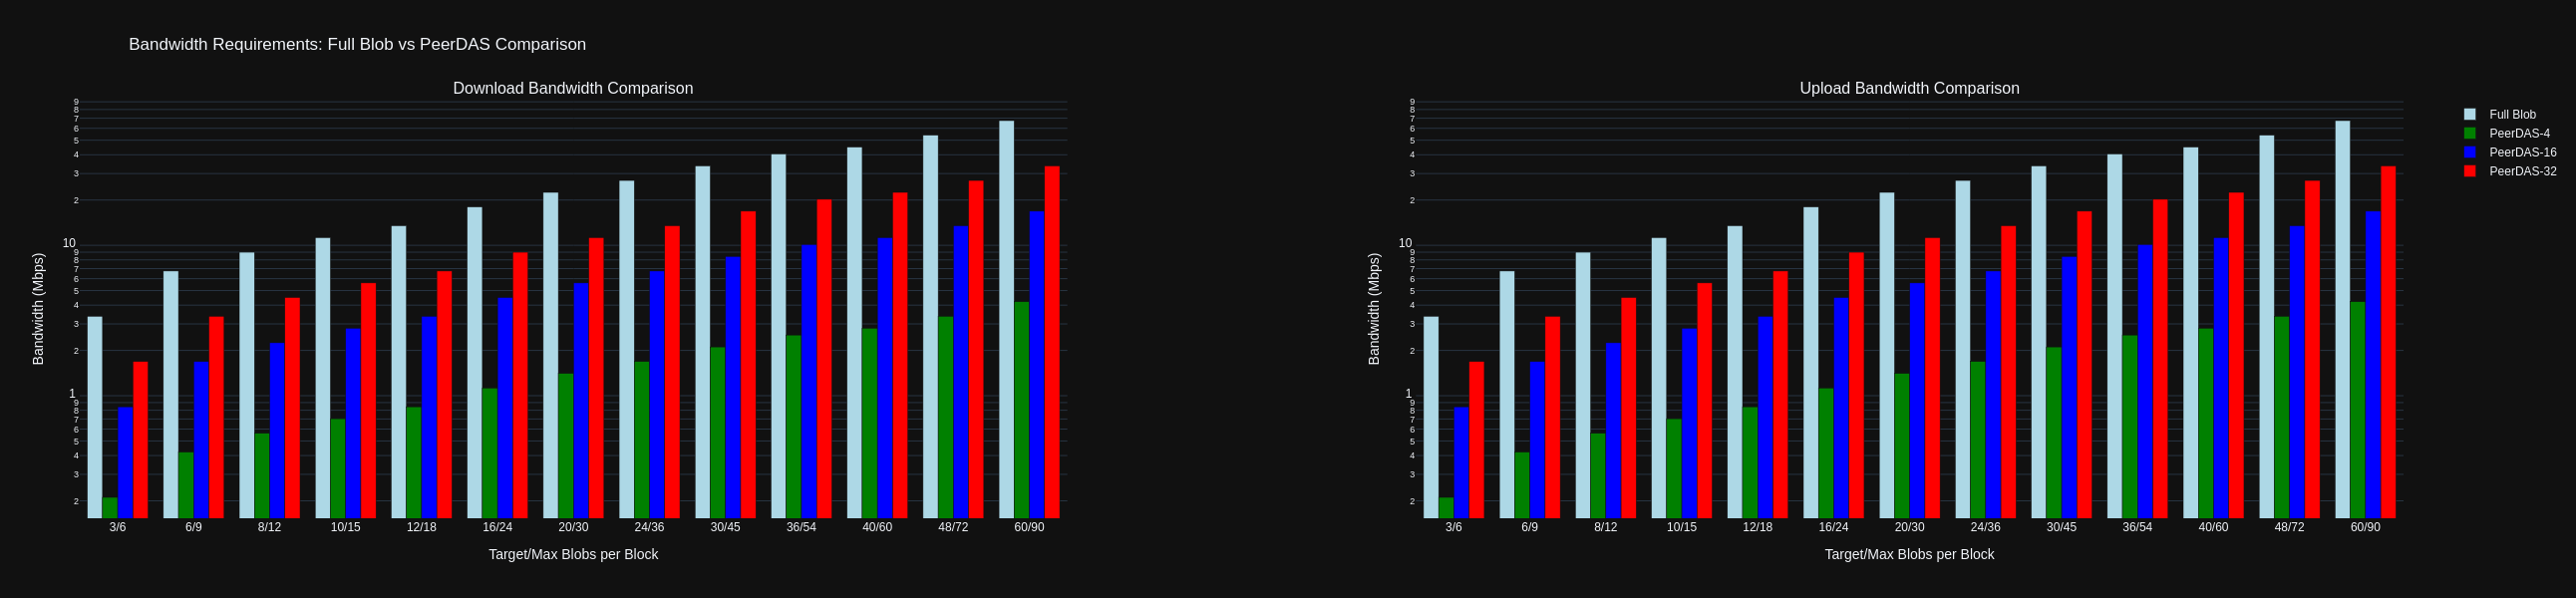

In [5]:
# 1. PeerDAS vs Full Blob Propagation Comparison
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Download Bandwidth Comparison', 'Upload Bandwidth Comparison'),
    horizontal_spacing=0.15
)

# Create scenario labels with only target/max blob counts
scenario_labels = [f"{row['target_blobs']}/{row['max_blobs']}" for _, row in df_results_full.iterrows()]

# Define methods to compare with colors
methods = [
    {'name': 'Full Blob', 'data': df_results_full, 'color': 'lightblue'},
    {'name': 'PeerDAS-4', 'data': df_results_peerdas[df_results_peerdas['custody_count'] == 4], 'color': 'green'},
    {'name': 'PeerDAS-16', 'data': df_results_peerdas[df_results_peerdas['custody_count'] == 16], 'color': 'blue'},
    {'name': 'PeerDAS-32', 'data': df_results_peerdas[df_results_peerdas['custody_count'] == 32], 'color': 'red'}
]

# Add traces for both download (col 1) and upload (col 2)
for i, method in enumerate(methods):
    # Download chart
    fig.add_trace(
        go.Bar(
            x=scenario_labels,
            y=method['data']['avg_download_mbps'],
            name=method['name'],
            marker_color=method['color'],
            offsetgroup=i+1
        ),
        row=1, col=1
    )
    
    # Upload chart (hide legend to avoid duplicates)
    fig.add_trace(
        go.Bar(
            x=scenario_labels,
            y=method['data']['avg_upload_mbps'],
            name=method['name'],
            marker_color=method['color'],
            offsetgroup=i+1,
            showlegend=False
        ),
        row=1, col=2
    )

fig.update_xaxes(title="Target/Max Blobs per Block")
fig.update_yaxes(type="log", title="Bandwidth (Mbps)")
fig.update_layout(
    title="Bandwidth Requirements: Full Blob vs PeerDAS Comparison",
    height=600,
    width=2400,
    barmode='group'
)

fig.show()

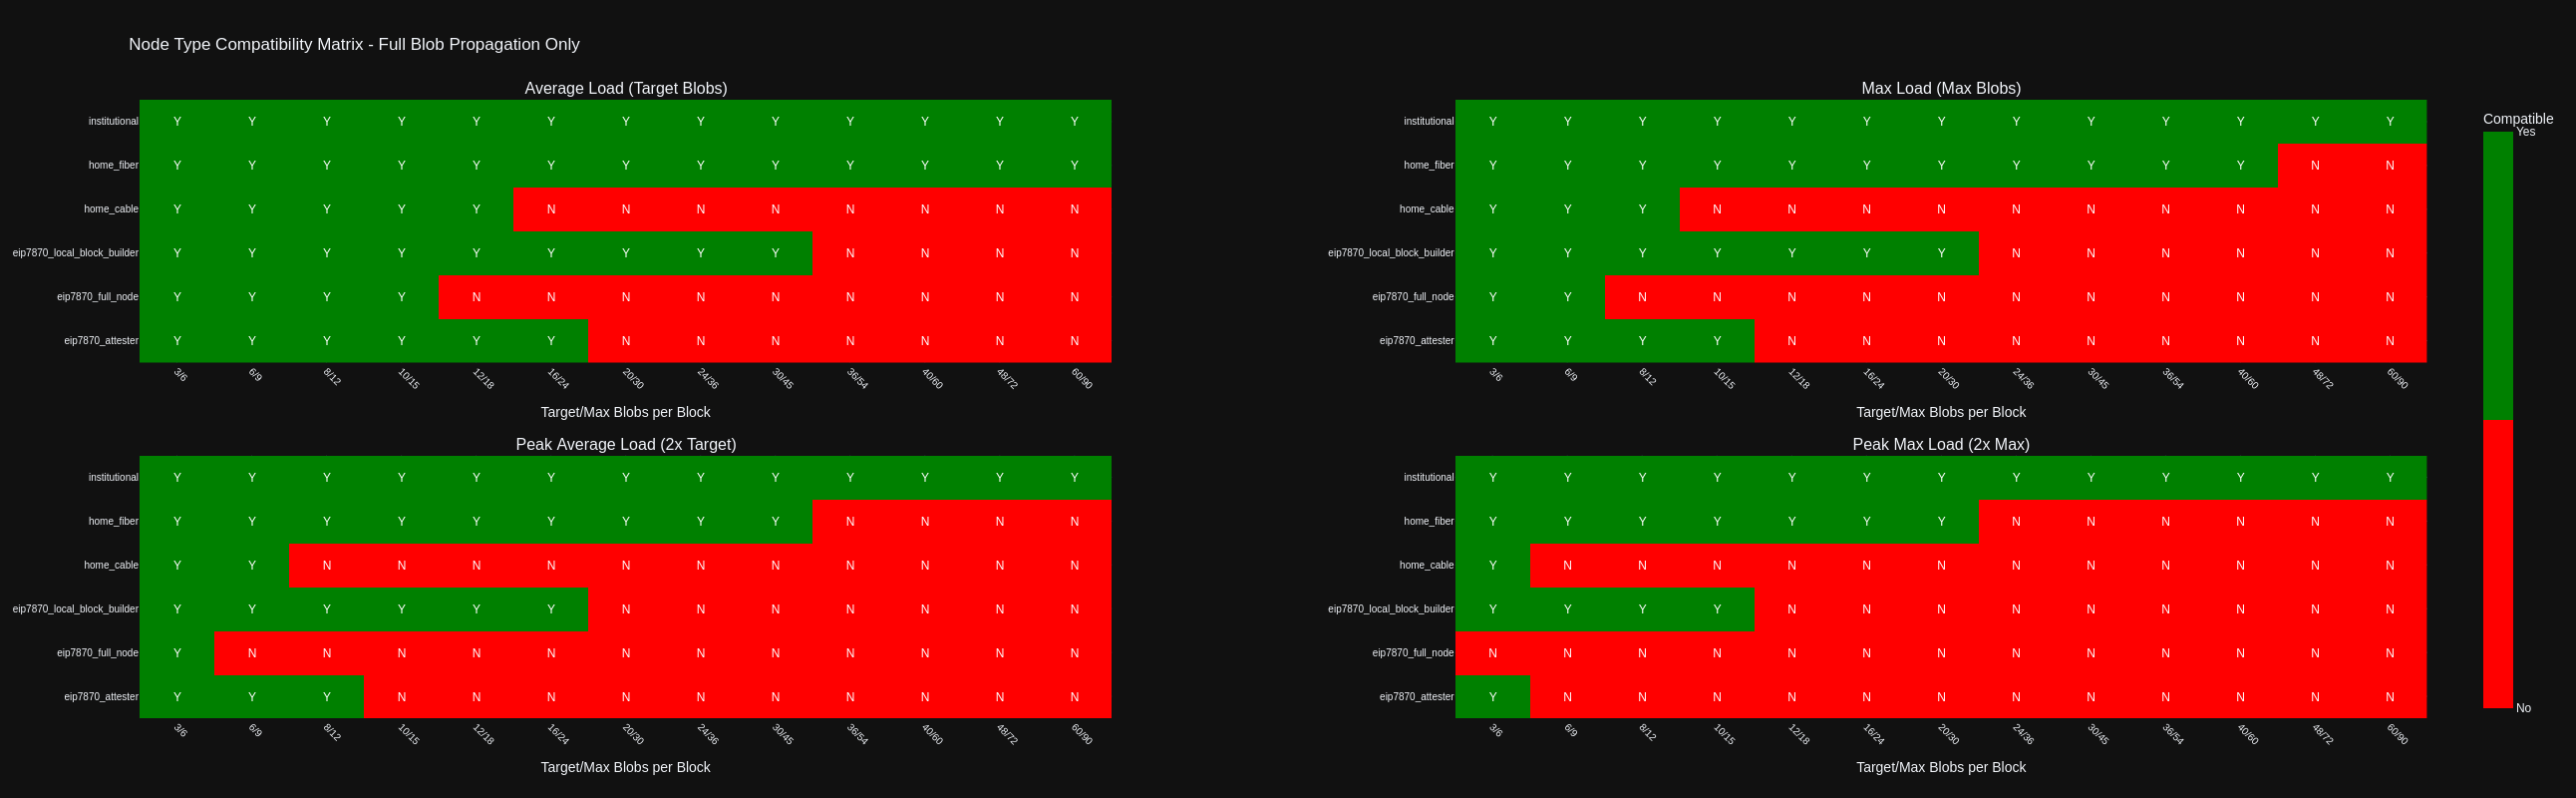


Node Type Bandwidth Limits (19% reserved for other operations):
----------------------------------------------------------------------

EIP-7870 Official Limits (Available for blob propagation):
Eip7870 Full Node    - Download:   40.0 Mbps, Upload:   12.0 Mbps
Eip7870 Attester     - Download:   40.0 Mbps, Upload:   20.0 Mbps
Eip7870 Local Block Builder - Download:   80.0 Mbps, Upload:   40.0 Mbps

Additional Connection Types (Available for blob propagation):
Home Cable           - Download:  160.0 Mbps, Upload:   16.0 Mbps
Home Fiber           - Download:  240.0 Mbps, Upload:   80.0 Mbps
Institutional        - Download:  800.0 Mbps, Upload:  800.0 Mbps

COMPATIBILITY SUMMARY (Full Blob Propagation):

Number of compatible scenarios (out of 13) for each node type:
----------------------------------------------------------------------
Eip7870 Attester     - Avg:  6, Max:  4, Peak Avg:  3, Peak Max:  1
Eip7870 Full Node    - Avg:  4, Max:  2, Peak Avg:  1, Peak Max:  0
Eip7870 Local Block

In [6]:
# 2. Node Compatibility Matrix - Full Blob Propagation (Upload/Download Split)

# Helper function to create compatibility matrix
def create_compatibility_matrix(df_results, load_type):
    """Create compatibility matrix for a specific load type."""
    compatibility_data = []
    
    for _, row in df_results.iterrows():
        for node_type, bandwidth in ALL_CONNECTION_TYPES.items():
            if load_type == "avg":
                compatible = check_node_compatibility(
                    row["avg_download"], row["avg_upload"], bandwidth
                )
            elif load_type == "max":
                compatible = check_node_compatibility(
                    row["max_download"], row["max_upload"], bandwidth
                )
            elif load_type == "peak_avg":
                compatible = check_node_compatibility(
                    row["peak_download"], row["peak_upload"], bandwidth
                )
            elif load_type == "peak_max":
                compatible = check_node_compatibility(
                    row["peak_max_download"], row["peak_max_upload"], bandwidth
                )
            
            compatibility_data.append({
                "scenario": f"{row['target_blobs']}/{row['max_blobs']}",
                "target_blobs": row['target_blobs'],
                "max_blobs": row['max_blobs'],
                "node_type": node_type,
                "compatible": compatible
            })
    
    df = pd.DataFrame(compatibility_data)
    # Sort by target_blobs and max_blobs before pivoting
    df = df.sort_values(['target_blobs', 'max_blobs'])
    # Get unique sorted scenarios
    sorted_scenarios = df[['scenario', 'target_blobs', 'max_blobs']].drop_duplicates().sort_values(['target_blobs', 'max_blobs'])['scenario'].tolist()
    # Pivot and reindex with sorted columns
    matrix = df.pivot(index='node_type', columns='scenario', values='compatible').astype(int)
    matrix = matrix[sorted_scenarios]  # Reorder columns
    return matrix

# Create all matrices
matrices = {
    "Average Load (Target Blobs)": create_compatibility_matrix(df_results_balanced, "avg"),
    "Max Load (Max Blobs)": create_compatibility_matrix(df_results_balanced, "max"),
    "Peak Average Load (2x Target)": create_compatibility_matrix(df_results_balanced, "peak_avg"),
    "Peak Max Load (2x Max)": create_compatibility_matrix(df_results_balanced, "peak_max")
}

# Create 2x2 subplot figure
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=list(matrices.keys()),
    horizontal_spacing=0.15,
    vertical_spacing=0.15
)

# Define discrete colorscale with only red and green
discrete_colorscale = [[0, 'red'], [0.5, 'red'], [0.5, 'green'], [1, 'green']]

# Add heatmaps to subplots
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]
for (title, matrix), (row, col) in zip(matrices.items(), positions):
    # Create text matrix with Y/N using map instead of deprecated applymap
    text_matrix = matrix.map(lambda x: "Y" if x == 1 else "N")
    
    fig.add_trace(
        go.Heatmap(
            z=matrix.values,
            x=matrix.columns,
            y=matrix.index,
            colorscale=discrete_colorscale,
            zmin=0,
            zmax=1,
            showscale=(row == 2 and col == 2),  # Only show scale on last plot
            text=text_matrix.values,
            texttemplate="%{text}",
            textfont={"size": 12, "color": "white"},
            colorbar=dict(title="Compatible", tickvals=[0, 1], ticktext=["No", "Yes"])
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title="Node Type Compatibility Matrix - Full Blob Propagation Only",
    height=800,
    width=1600,
    showlegend=False
)
fig.update_xaxes(title="Target/Max Blobs per Block", tickangle=45, tickfont=dict(size=10))
fig.update_yaxes(tickfont=dict(size=10))

fig.show()

# Display bandwidth limits
def display_bandwidth_limits():
    """Display formatted bandwidth limits table."""
    print(f"\nNode Type Bandwidth Limits ({int((1-BANDWIDTH_AVAILABLE_FACTOR)*100)}% reserved for other operations):")
    print("-" * 70)
    
    print("\nEIP-7870 Official Limits (Available for blob propagation):")
    for node_type, bw in EIP_7870_BANDWIDTH_LIMITS.items():
        down_mbps = (bw["down"] * BANDWIDTH_AVAILABLE_FACTOR * 8) / (1024 * 1024)
        up_mbps = (bw["up"] * BANDWIDTH_AVAILABLE_FACTOR * 8) / (1024 * 1024)
        print(f"{node_type.replace('_', ' ').title():20} - Download: {down_mbps:6.1f} Mbps, Upload: {up_mbps:6.1f} Mbps")
    
    print("\nAdditional Connection Types (Available for blob propagation):")
    for node_type, bw in ADDITIONAL_CONNECTION_TYPES.items():
        down_mbps = (bw["down"] * BANDWIDTH_AVAILABLE_FACTOR * 8) / (1024 * 1024)
        up_mbps = (bw["up"] * BANDWIDTH_AVAILABLE_FACTOR * 8) / (1024 * 1024)
        print(f"{node_type.replace('_', ' ').title():20} - Download: {down_mbps:6.1f} Mbps, Upload: {up_mbps:6.1f} Mbps")

# Display compatibility summary
def display_compatibility_summary(matrices):
    """Display summary statistics for compatibility across all load types."""
    print("\n" + "=" * 70)
    print("COMPATIBILITY SUMMARY (Full Blob Propagation):")
    print("=" * 70)
    print("\nNumber of compatible scenarios (out of 13) for each node type:")
    print("-" * 70)
    
    node_types = list(matrices.values())[0].index
    
    for node_type in node_types:
        counts = [matrix.loc[node_type].sum() for matrix in matrices.values()]
        print(f"{node_type.replace('_', ' ').title():20} - Avg: {counts[0]:2d}, Max: {counts[1]:2d}, "
              f"Peak Avg: {counts[2]:2d}, Peak Max: {counts[3]:2d}")

# Display failure thresholds
def display_failure_thresholds(matrices):
    """Display the first failure point for each node type and load condition."""
    print("\n" + "=" * 70)
    print("FAILURE THRESHOLDS (first incompatible scenario) - Full Blob Only:")
    print("=" * 70)
    
    node_types = list(matrices.values())[0].index
    
    for node_type in node_types:
        print(f"\n{node_type.replace('_', ' ').title()}:")
        
        for load_type, matrix in matrices.items():
            row = matrix.loc[node_type]
            failures = row[row == 0]
            
            if len(failures) > 0:
                first_failure = failures.index[0]
                # Extract target/max from the label
                target_max = first_failure.split('/')
                load_label = load_type.split('(')[0].strip()
                print(f"  {load_label:18} fails at: {first_failure} blobs")
            else:
                load_label = load_type.split('(')[0].strip()
                print(f"  {load_label:18} fails at: Never (all scenarios compatible)")

# Execute display functions
display_bandwidth_limits()
display_compatibility_summary(matrices)
display_failure_thresholds(matrices)

print("\nNote: For PeerDAS compatibility analysis, see section 'PeerDAS vs Full Blob Analysis'")

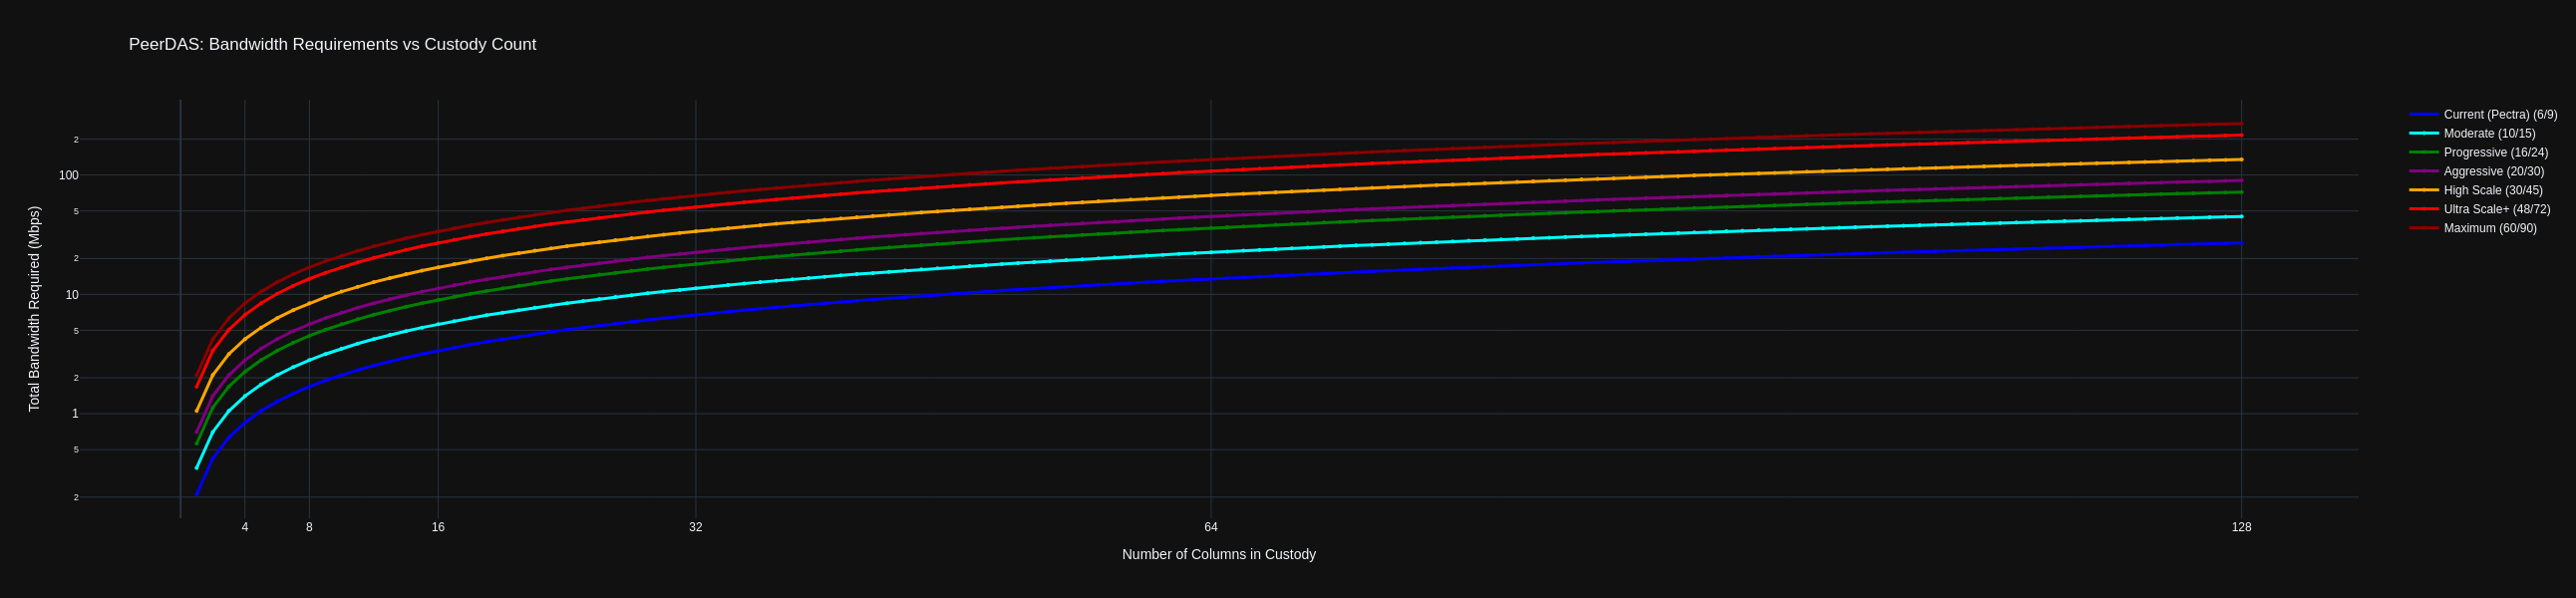

In [7]:
# 3. PeerDAS Custody Impact Analysis
# Show how different custody counts affect bandwidth for various blob scenarios

# Select more blob scenarios for comprehensive analysis
key_blob_scenarios = ["Current (Pectra)", "Moderate", "Progressive", "Aggressive", "High Scale", "Ultra Scale+", "Maximum"]

# Generate data for all custody counts from 1 to 128
custody_counts = list(range(1, 129))

fig = go.Figure()

# Color map for scenarios
scenario_colors = {
    "Current (Pectra)": "blue",
    "Moderate": "cyan",
    "Progressive": "green", 
    "Aggressive": "purple",
    "High Scale": "orange",
    "Ultra Scale+": "red",
    "Maximum": "darkred"
}

for scenario_name in key_blob_scenarios:
    scenario_details = next(s for s in BLOB_LIMIT_SCENARIOS if s["name"] == scenario_name)
    
    x_values = []
    y_values = []
    
    for custody_count in custody_counts:
        # Calculate bandwidth for this scenario and custody count
        reqs = calculate_bandwidth_requirements(
            scenario_details["target"], scenario_details["max"], "balanced", 
            custody_count=custody_count, use_peerdas=True
        )
        x_values.append(custody_count)
        y_values.append(reqs["avg_bandwidth_total_mbps"])
    
    fig.add_trace(go.Scatter(
        x=x_values,
        y=y_values,
        mode='lines+markers',
        name=f"{scenario_name} ({scenario_details['target']}/{scenario_details['max']})",
        line=dict(width=3, color=scenario_colors[scenario_name]),
        marker=dict(size=4)
    ))

fig.update_layout(
    title="PeerDAS: Bandwidth Requirements vs Custody Count",
    xaxis_title="Number of Columns in Custody",
    yaxis_title="Total Bandwidth Required (Mbps)",
    height=600,
    width=1200,
    yaxis_type="log",
    hovermode='x unified'
)

fig.update_xaxes(tickvals=[4, 8, 16, 32, 64, 128])

fig.show()

In [8]:
# 4. Monthly Data Transfer Visualization

# Filter to show only Full Blob data
df_monthly_full = df_monthly[df_monthly['method'] == 'Full Blob']

# Create subplots for average and maximum
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Average Monthly Data Transfer (Target Blobs)', 'Maximum Monthly Data Transfer (Max Blobs)'),
    horizontal_spacing=0.12
)

# Define colors for different methods
method_colors = {
    'Full Blob': 'lightblue',
    'PeerDAS-4': 'green',
    'PeerDAS-8': 'cyan', 
    'PeerDAS-16': 'blue',
    'PeerDAS-32': 'purple'
}

# Left plot: Average (Target) data transfer
# Add Full Blob average line
fig.add_trace(go.Scatter(
    x=[f"{row['target_blobs']}/{row['max_blobs']}" for _, row in df_monthly_full.iterrows()],
    y=df_monthly_full['avg_monthly_tb'],
    mode='lines+markers',
    name='Full Blob',
    line=dict(width=3, color=method_colors['Full Blob']),
    marker=dict(size=8),
    legendgroup='avg'
), row=1, col=1)

# Add PeerDAS lines for various custody counts (4, 8, 16, 32)
for custody in [4, 8, 16, 32]:
    df_monthly_custody = df_monthly[df_monthly['custody_count'] == custody]
    
    fig.add_trace(go.Scatter(
        x=[f"{row['target_blobs']}/{row['max_blobs']}" for _, row in df_monthly_custody.iterrows()],
        y=df_monthly_custody['avg_monthly_tb'],
        mode='lines+markers',
        name=f'PeerDAS-{custody}',
        line=dict(width=2, color=method_colors.get(f'PeerDAS-{custody}', 'gray')),
        marker=dict(size=6),
        legendgroup='avg'
    ), row=1, col=1)

# Right plot: Maximum data transfer
# Add Full Blob maximum line
fig.add_trace(go.Scatter(
    x=[f"{row['target_blobs']}/{row['max_blobs']}" for _, row in df_monthly_full.iterrows()],
    y=df_monthly_full['max_monthly_tb'],
    mode='lines+markers',
    name='Full Blob',
    line=dict(width=3, color=method_colors['Full Blob']),
    marker=dict(size=8),
    legendgroup='max',
    showlegend=False
), row=1, col=2)

# Add PeerDAS maximum lines for various custody counts (4, 8, 16, 32)
for custody in [4, 8, 16, 32]:
    df_monthly_custody = df_monthly[df_monthly['custody_count'] == custody]
    
    fig.add_trace(go.Scatter(
        x=[f"{row['target_blobs']}/{row['max_blobs']}" for _, row in df_monthly_custody.iterrows()],
        y=df_monthly_custody['max_monthly_tb'],
        mode='lines+markers',
        name=f'PeerDAS-{custody}',
        line=dict(width=2, color=method_colors.get(f'PeerDAS-{custody}', 'gray')),
        marker=dict(size=6),
        legendgroup='max',
        showlegend=False
    ), row=1, col=2)

# Update axes
fig.update_xaxes(title="Target/Max Blobs per Block", tickangle=45)
fig.update_yaxes(title="Data Transfer (TB/month)", type="log", matches='y')

fig.update_layout(
    title="Monthly Data Transfer Requirements: Full Blob vs PeerDAS",
    height=600,
    width=1600,
    hovermode='x unified'
)

fig.show()

In [9]:
# 5. Bandwidth Scaling Analysis (Extended to 72 blobs)
blob_range = np.arange(1, 73)
bandwidth_scaling = []

# Define PeerDAS custody counts to include
custody_counts = [4, 16, 32]  # Key PeerDAS scenarios

# Calculate for Full Blob and PeerDAS scenarios
for blobs in blob_range:
    # Full Blob propagation
    reqs_full = calculate_bandwidth_requirements(blobs, blobs, "balanced", use_peerdas=False)
    bandwidth_scaling.append({
        "blobs": blobs,
        "method": "Full Blob",
        "custody_count": None,
        "avg_download_mbps": reqs_full["avg_download_mbps"],
        "avg_upload_mbps": reqs_full["avg_upload_mbps"],
        "peak_download_mbps": reqs_full["peak_download_mbps"],
        "peak_upload_mbps": reqs_full["peak_upload_mbps"],
        "avg_bandwidth_total_mbps": reqs_full["avg_bandwidth_total_mbps"]
    })
    
    # PeerDAS propagation for different custody counts
    for custody in custody_counts:
        reqs_peerdas = calculate_bandwidth_requirements(
            blobs, blobs, "balanced", 
            custody_count=custody, use_peerdas=True
        )
        bandwidth_scaling.append({
            "blobs": blobs,
            "method": f"PeerDAS-{custody}",
            "custody_count": custody,
            "avg_download_mbps": reqs_peerdas["avg_download_mbps"],
            "avg_upload_mbps": reqs_peerdas["avg_upload_mbps"],
            "peak_download_mbps": reqs_peerdas["peak_download_mbps"],
            "peak_upload_mbps": reqs_peerdas["peak_upload_mbps"],
            "avg_bandwidth_total_mbps": reqs_peerdas["avg_bandwidth_total_mbps"]
        })

df_scaling = pd.DataFrame(bandwidth_scaling)

# Create 2x2 subplots: rows for download/upload, columns for average/peak
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Average Download', 'Peak Download', 
                    'Average Upload', 'Peak Upload'),
    horizontal_spacing=0.12,
    vertical_spacing=0.12
)

# Define colors for different methods
method_colors = {
    'Full Blob': 'lightblue',
    'PeerDAS-4': 'green',
    'PeerDAS-16': 'blue',
    'PeerDAS-32': 'red'
}

# Plot each method in all four subplots
for method in ['Full Blob'] + [f'PeerDAS-{c}' for c in custody_counts]:
    method_data = df_scaling[df_scaling['method'] == method]
    
    # Average Download (top-left)
    fig.add_trace(go.Scatter(
        x=method_data['blobs'],
        y=method_data['avg_download_mbps'],
        mode='lines',
        name=method,
        line=dict(width=3, color=method_colors[method]),
        legendgroup=method
    ), row=1, col=1)
    
    # Peak Download (top-right)
    fig.add_trace(go.Scatter(
        x=method_data['blobs'],
        y=method_data['peak_download_mbps'],
        mode='lines',
        name=method,
        line=dict(width=3, color=method_colors[method]),
        legendgroup=method,
        showlegend=False
    ), row=1, col=2)
    
    # Average Upload (bottom-left)
    fig.add_trace(go.Scatter(
        x=method_data['blobs'],
        y=method_data['avg_upload_mbps'],
        mode='lines',
        name=method,
        line=dict(width=3, color=method_colors[method]),
        legendgroup=method,
        showlegend=False
    ), row=2, col=1)
    
    # Peak Upload (bottom-right)
    fig.add_trace(go.Scatter(
        x=method_data['blobs'],
        y=method_data['peak_upload_mbps'],
        mode='lines',
        name=method,
        line=dict(width=3, color=method_colors[method]),
        legendgroup=method,
        showlegend=False
    ), row=2, col=2)

# Add vertical lines for key scenarios to all subplots
for scenario in BLOB_LIMIT_SCENARIOS[::2]:  # Every other scenario to avoid crowding
    for row in [1, 2]:
        for col in [1, 2]:
            fig.add_vline(
                x=scenario["target"],
                line_dash="dot",
                line_color="gray",
                opacity=0.3,
                row=row, col=col
            )

# Update axes - using matches='y' to sync y-axes across all subplots
fig.update_xaxes(title="Number of Blobs per Block", range=[20, 73])
fig.update_yaxes(title="Bandwidth Required (Mbps)", matches='y')

fig.update_layout(
    title="Bandwidth Scaling Analysis: Full Blob vs PeerDAS (20-72 blobs)",
    height=800,
    width=1600,
    hovermode='x unified'
)

fig.show()

## PeerDAS vs Full Blob Analysis

In [10]:
# Comprehensive PeerDAS vs Full Blob Comparison

print("=" * 80)
print("PEERDAS VS FULL BLOB: COMPARATIVE ANALYSIS")
print(f"Using {NETWORK_HOPS} network hops ({SECONDS_PER_HOP:.2f}s per hop)")
print(f"Bandwidth allocation: {int(BANDWIDTH_AVAILABLE_FACTOR*100)}% available for blob propagation")
print("=" * 80)

# 1. Node Type Compatibility Comparison (Using Peak Average Requirements)
print("\n1. MAXIMUM VIABLE BLOB COUNTS BY NODE TYPE (Peak Average Load)")
print("-" * 60)
print("Analysis based on peak average requirements (2x target blobs) for realistic peak scenarios")
print(f"Note: Only {int((1-BANDWIDTH_AVAILABLE_FACTOR)*100)}% bandwidth reserved for other operations\n")

viability_comparison = []
for node_type, bandwidth in ALL_CONNECTION_TYPES.items():
    # Find maximum viable blobs for Full Blob
    max_full = 0
    for scenario in BLOB_LIMIT_SCENARIOS:
        reqs = calculate_bandwidth_requirements(
            scenario["target"], scenario["max"], "balanced", use_peerdas=False
        )
        # Use peak average bandwidth requirements (2x target blobs)
        if check_node_compatibility(reqs["peak_download"], reqs["peak_upload"], bandwidth):
            max_full = scenario["target"]  # Use target instead of max
    
    # Find maximum viable blobs for PeerDAS scenarios
    max_das = {}
    for custody in [4, 8, 16, 32]:
        max_blobs = 0
        for scenario in BLOB_LIMIT_SCENARIOS:
            reqs = calculate_bandwidth_requirements(
                scenario["target"], scenario["max"], "balanced",
                custody_count=custody, use_peerdas=True
            )
            # Use peak average bandwidth requirements
            if check_node_compatibility(reqs["peak_download"], reqs["peak_upload"], bandwidth):
                max_blobs = scenario["target"]  # Use target instead of max
        max_das[custody] = max_blobs
    
    viability_comparison.append({
        "node_type": node_type,
        "full_blob": max_full,
        **{f"peerdas_{k}": v for k, v in max_das.items()}
    })

df_viability = pd.DataFrame(viability_comparison)

# Display EIP-7870 nodes first, then additional types
print("EIP-7870 Official Node Types:")
print(f"{'Node Type':<30} {'Full':<6} {'PeerDAS-4':<10} {'PeerDAS-8':<10} {'PeerDAS-16':<11} {'PeerDAS-32':<11}")
print("-" * 82)
for _, row in df_viability.iterrows():
    if row['node_type'] in EIP_7870_BANDWIDTH_LIMITS:
        # Remove eip7870_ prefix for display and show bandwidth
        display_name = row['node_type'].replace('eip7870_', '').replace('_', ' ').title()
        bw = EIP_7870_BANDWIDTH_LIMITS[row['node_type']]
        down_mbps = int((bw["down"] * 8) / (1024 * 1024))
        up_mbps = int((bw["up"] * 8) / (1024 * 1024))
        full_name = f"{display_name} ({down_mbps}/{up_mbps})"
        print(f"{full_name:<30} {row['full_blob']:<6} {row['peerdas_4']:<10} "
              f"{row['peerdas_8']:<10} {row['peerdas_16']:<11} {row['peerdas_32']:<11}")

print("\nAdditional Connection Types (for reference):")
print("-" * 82)
for _, row in df_viability.iterrows():
    if row['node_type'] in ADDITIONAL_CONNECTION_TYPES:
        display_name = row['node_type'].replace('_', ' ').title()
        bw = ADDITIONAL_CONNECTION_TYPES[row['node_type']]
        down_mbps = int((bw["down"] * 8) / (1024 * 1024))
        up_mbps = int((bw["up"] * 8) / (1024 * 1024))
        full_name = f"{display_name} ({down_mbps}/{up_mbps})"
        print(f"{full_name:<30} {row['full_blob']:<6} {row['peerdas_4']:<10} "
              f"{row['peerdas_8']:<10} {row['peerdas_16']:<11} {row['peerdas_32']:<11}")

# 2. Scaling Enablement Analysis
print("\n\n2. SCALING BENEFITS WITH PEERDAS")
print("-" * 60)
print("How PeerDAS enables higher blob counts for EIP-7870 node types:\n")

for node_type in ["eip7870_full_node", "eip7870_attester", "eip7870_local_block_builder"]:
    node_data = df_viability[df_viability['node_type'] == node_type].iloc[0]
    full_max = node_data['full_blob']
    
    # Get bandwidth for display
    bw = EIP_7870_BANDWIDTH_LIMITS[node_type]
    down_mbps = int((bw["down"] * 8) / (1024 * 1024))
    up_mbps = int((bw["up"] * 8) / (1024 * 1024))
    
    # Remove prefix for display
    display_name = node_type.replace('eip7870_', '').replace('_', ' ').title()
    print(f"{display_name} ({down_mbps}/{up_mbps} Mbps):")
    print(f"  Full Blob capacity: {full_max} target blobs")
    
    # Show best improvements only
    best_improvement = 0
    best_custody = None
    for custody in [4, 8, 16, 32]:
        peerdas_max = node_data[f'peerdas_{custody}']
        if peerdas_max > full_max:
            improvement = peerdas_max - full_max
            if improvement > best_improvement:
                best_improvement = improvement
                best_custody = custody
    
    if best_custody:
        best_max = node_data[f'peerdas_{best_custody}']
        improvement_pct = ((best_max - full_max) / full_max) * 100 if full_max > 0 else float('inf')
        print(f"  Best PeerDAS option: PeerDAS-{best_custody} → {best_max} blobs (+{best_improvement}, {improvement_pct:.0f}% increase)")
        
        # Show the progression
        print(f"  PeerDAS scaling options:")
        for custody in [4, 8, 16, 32]:
            peerdas_max = node_data[f'peerdas_{custody}']
            if peerdas_max >= full_max:
                print(f"    PeerDAS-{custody:2d}: {peerdas_max} blobs")
    else:
        print(f"  PeerDAS provides no benefit (limited by other factors)")
    print()

# 3. Bandwidth Requirements Analysis
print("\n3. BANDWIDTH REQUIREMENTS ANALYSIS")
print("-" * 60)
print("Peak average bandwidth requirements for key scenarios:\n")

key_scenarios = ["Current (Pectra)", "Progressive", "High Scale", "Maximum"]
for scenario_name in key_scenarios:
    scenario = next(s for s in BLOB_LIMIT_SCENARIOS if s["name"] == scenario_name)
    
    print(f"{scenario_name} ({scenario['target']}/{scenario['max']} blobs):")
    
    # Full blob
    full_reqs = calculate_bandwidth_requirements(
        scenario["target"], scenario["max"], "balanced", use_peerdas=False
    )
    peak_total = full_reqs['peak_download_mbps'] + full_reqs['peak_upload_mbps']
    print(f"  Full Blob:  {peak_total:.1f} Mbps total (↓{full_reqs['peak_download_mbps']:.1f} ↑{full_reqs['peak_upload_mbps']:.1f})")
    
    # PeerDAS variants - show key custody levels
    for custody in [4, 16, 32]:
        peerdas_reqs = calculate_bandwidth_requirements(
            scenario["target"], scenario["max"], "balanced",
            custody_count=custody, use_peerdas=True
        )
        peerdas_peak_total = peerdas_reqs['peak_download_mbps'] + peerdas_reqs['peak_upload_mbps']
        reduction = (1 - peerdas_peak_total / peak_total) * 100
        print(f"  PeerDAS-{custody:2d}: {peerdas_peak_total:.1f} Mbps total (↓{peerdas_reqs['peak_download_mbps']:.1f} ↑{peerdas_reqs['peak_upload_mbps']:.1f}) - {reduction:.0f}% reduction")
    print()

PEERDAS VS FULL BLOB: COMPARATIVE ANALYSIS
Using 3 network hops (1.33s per hop)
Bandwidth allocation: 80% available for blob propagation

1. MAXIMUM VIABLE BLOB COUNTS BY NODE TYPE (Peak Average Load)
------------------------------------------------------------
Analysis based on peak average requirements (2x target blobs) for realistic peak scenarios
Note: Only 19% bandwidth reserved for other operations

EIP-7870 Official Node Types:
Node Type                      Full   PeerDAS-4  PeerDAS-8  PeerDAS-16  PeerDAS-32 
----------------------------------------------------------------------------------
Full Node (50/15)              3      60         40         20          10         
Attester (50/25)               8      60         60         30          16         
Local Block Builder (100/50)   16     60         60         60          30         

Additional Connection Types (for reference):
----------------------------------------------------------------------------------
Home Cable (2

## Summary and Recommendations

In [11]:
# Key Findings and Implementation Considerations

print("\n" + "=" * 80)
print("KEY FINDINGS AND IMPLEMENTATION CONSIDERATIONS")
print("=" * 80)

print("\n1. EIP-7870 NODE TYPE SUITABILITY:")
print("-" * 50)

# Analyze each EIP-7870 node type
for node_type in ["eip7870_full_node", "eip7870_attester", "eip7870_local_block_builder"]:
    bw = EIP_7870_BANDWIDTH_LIMITS[node_type]
    down_mbps = int((bw["down"] * 8) / (1024 * 1024))
    up_mbps = int((bw["up"] * 8) / (1024 * 1024))
    display_name = node_type.replace('eip7870_', '').replace('_', ' ').title()
    
    # Check Pectra compatibility
    pectra_reqs = calculate_bandwidth_requirements(6, 9, "balanced", use_peerdas=False)
    peak_compatible = check_node_compatibility(pectra_reqs["peak_download"], pectra_reqs["peak_upload"], bw)
    
    # Find max capacity
    max_target = 0
    for scenario in BLOB_LIMIT_SCENARIOS:
        reqs = calculate_bandwidth_requirements(scenario["target"], scenario["max"], "balanced", use_peerdas=False)
        if check_node_compatibility(reqs["peak_download"], reqs["peak_upload"], bw):
            max_target = scenario["target"]
    
    print(f"\n{display_name} ({down_mbps}/{up_mbps} Mbps):")
    if peak_compatible:
        print(f"  ✓ Supports current Pectra (6/9 blobs) under peak conditions")
    else:
        print(f"  ✗ Cannot handle Pectra peak loads - requires PeerDAS")
    
    print(f"  Maximum target blob capacity: {max_target} blobs")
    
    if max_target >= 30:
        print(f"  Assessment: Excellent - Ready for high-scale blockchain scenarios")
    elif max_target >= 16:
        print(f"  Assessment: Good - Supports progressive scaling scenarios")
    elif max_target >= 6:
        print(f"  Assessment: Adequate - Suitable for current and near-term scenarios")
    else:
        print(f"  Assessment: Limited - May require PeerDAS for current operations")

print(f"\n\n2. PEERDAS ADOPTION BENEFITS:")
print("-" * 50)

# Show PeerDAS benefits
peerdas_scenarios = [
    {"name": "PeerDAS-4 (3.1% custody)", "custody": 4},
    {"name": "PeerDAS-16 (12.5% custody)", "custody": 16},
    {"name": "PeerDAS-32 (25% custody)", "custody": 32}
]

progressive_reqs = calculate_bandwidth_requirements(16, 24, "balanced", use_peerdas=False)
progressive_total = progressive_reqs['peak_download_mbps'] + progressive_reqs['peak_upload_mbps']

print(f"\nProgressive scenario (16/24 blobs) bandwidth reduction:")
for scenario in peerdas_scenarios:
    peerdas_reqs = calculate_bandwidth_requirements(16, 24, "balanced", custody_count=scenario['custody'], use_peerdas=True)
    peerdas_total = peerdas_reqs['peak_download_mbps'] + peerdas_reqs['peak_upload_mbps']
    reduction = (1 - peerdas_total / progressive_total) * 100
    
    print(f"  {scenario['name']}: {reduction:.0f}% bandwidth reduction")

print(f"\nNode type enablement with PeerDAS-16:")
for node_type in ["eip7870_full_node", "eip7870_attester", "eip7870_local_block_builder"]:
    display_name = node_type.replace('eip7870_', '').replace('_', ' ').title()
    bw = EIP_7870_BANDWIDTH_LIMITS[node_type]
    
    # Find max with PeerDAS-16
    max_peerdas = 0
    max_full = 0
    
    for scenario in BLOB_LIMIT_SCENARIOS:
        # Full blob
        reqs_full = calculate_bandwidth_requirements(scenario["target"], scenario["max"], "balanced", use_peerdas=False)
        if check_node_compatibility(reqs_full["peak_download"], reqs_full["peak_upload"], bw):
            max_full = scenario["target"]
        
        # PeerDAS-16
        reqs_peerdas = calculate_bandwidth_requirements(scenario["target"], scenario["max"], "balanced", custody_count=16, use_peerdas=True)
        if check_node_compatibility(reqs_peerdas["peak_download"], reqs_peerdas["peak_upload"], bw):
            max_peerdas = scenario["target"]
    
    improvement = max_peerdas - max_full
    if improvement > 0:
        print(f"  {display_name}: +{improvement} target blobs capacity increase")
    else:
        print(f"  {display_name}: No additional capacity (already sufficient)")

print(f"\n\n3. NETWORK ARCHITECTURE CONSIDERATIONS:")
print("-" * 50)

print(f"\nCurrent modeling assumptions:")
print(f"  • {NETWORK_HOPS}-hop propagation model ({SECONDS_PER_HOP:.2f}s per hop)")
print(f"  • {int(BANDWIDTH_AVAILABLE_FACTOR*100)}% bandwidth allocated to blob data")
print(f"  • {int((GOSSIP_OVERHEAD-1)*100)}% gossip protocol overhead")
print(f"  • {PEAK_FACTOR}x peak load factor for network congestion")

print(f"\nCritical bottlenecks:")
# Check which is more limiting - upload or download
test_reqs = calculate_bandwidth_requirements(16, 24, "balanced", use_peerdas=False)
if test_reqs['peak_upload_mbps'] > test_reqs['peak_download_mbps']:
    print(f"  • Upload bandwidth is primary constraint (asymmetric connections)")
else:
    print(f"  • Download bandwidth is primary constraint")

print(f"  • Peak scenarios critical for network stability")
print(f"  • EIP-7870 attester nodes have better upload capacity than full nodes")

print(f"\n\n4. DEPLOYMENT RECOMMENDATIONS:")
print("-" * 50)

print(f"\nPhased adoption strategy:")
print(f"  Phase 1: Deploy current Pectra (6/9 blobs) with existing infrastructure")
print(f"  Phase 2: Implement PeerDAS-16 to enable progressive scaling (16/24 blobs)")
print(f"  Phase 3: Consider higher blob counts (30+ blobs) for specialized node operators")

print(f"\nNode operator guidance:")
print(f"  • EIP-7870 Local Block Builder: Best positioned for high blob counts")
print(f"  • EIP-7870 Attester: Good balance of capability and requirements") 
print(f"  • EIP-7870 Full Node: May benefit from PeerDAS for future scaling")

print(f"\nPeerDAS configuration recommendations:")
print(f"  • PeerDAS-16: Optimal balance of efficiency and network resilience")
print(f"  • PeerDAS-4: For bandwidth-constrained environments only")
print(f"  • PeerDAS-32: For high-capacity nodes in data-heavy scenarios")


KEY FINDINGS AND IMPLEMENTATION CONSIDERATIONS

1. EIP-7870 NODE TYPE SUITABILITY:
--------------------------------------------------

Full Node (50/15 Mbps):
  ✗ Cannot handle Pectra peak loads - requires PeerDAS
  Maximum target blob capacity: 3 blobs
  Assessment: Limited - May require PeerDAS for current operations

Attester (50/25 Mbps):
  ✓ Supports current Pectra (6/9 blobs) under peak conditions
  Maximum target blob capacity: 8 blobs
  Assessment: Adequate - Suitable for current and near-term scenarios

Local Block Builder (100/50 Mbps):
  ✓ Supports current Pectra (6/9 blobs) under peak conditions
  Maximum target blob capacity: 16 blobs
  Assessment: Good - Supports progressive scaling scenarios


2. PEERDAS ADOPTION BENEFITS:
--------------------------------------------------

Progressive scenario (16/24 blobs) bandwidth reduction:
  PeerDAS-4 (3.1% custody): 94% bandwidth reduction
  PeerDAS-16 (12.5% custody): 75% bandwidth reduction
  PeerDAS-32 (25% custody): 50% bandw